# Pandas

Исходные данные о покупках людей содержатся в формате:
id – означает покупку (в одну покупку входят все товары, купленные пользователем во время 1 похода в магазин)
Товар – наименование товара
Количество – число единиц купленного товара
Воспользуйтесь этими данными и выясните, какие пары товаров пользователи чаще всего покупают вместе. По сути, вам необходимо найти паттерны покупок, что позволит оптимизировать размещение продуктов в магазине, для удобства пользователей и увеличения выручки.
1_Товар – наименование первого товара
2_Товар – наименование второго товара
Встречаемость – число раз, когда такая пара была встречена
Другими словами: 2 раза люди покупали одновременно чай и арбуз, 1 раз одновременно покупали арбуз и сгущёнку и 1 раз одновременно были куплены чай со сгущёнкой.

In [2]:
import pandas as pd
from itertools import combinations

ModuleNotFoundError: No module named 'pandas'

In [158]:
data = pd.read_csv('https://stepik.org/media/attachments/lesson/409319/test1_completed.csv')

In [159]:
data.head(10)

id            Товар  Количество
0  17119            Лимон        1.10
1  17119  Лимон оранжевый        0.70
2  17119        Лук-порей       10.00
3  17119     Лук репчатый        2.50
4  17119    Малина свежая        1.00
5  17119  Морковь немытая        1.40
6  17119  Черешня сушеная        1.80
7  17530  Лимон оранжевый        0.25
8  17530     Изюм Султана        0.50
9  17530  Капуста цветная        2.00

In [160]:
# Посмотрим сколько уникальных продуктов в датасете и сколько максимум позиций в одной покупке

len(data['Товар'].unique())

199

In [161]:
data.groupby('id', as_index=False).agg({'Товар': 'count'}).sort_values(by='Товар', ascending=False)i

id  Товар
2638  99430     64
670   38766     62
160   23467     61
2123  83977     59
1903  77120     56
...     ...    ...
2221  87396      1
94    21413      1
626   37090      1
95    21432      1
1401  61029      1

[3273 rows x 2 columns]

In [162]:
# Что бы посчитать все возможные пары продуктов для каждой покупки возпользуемся модулем itertools.combinations

couples = lambda x : pd.DataFrame(list(combinations(x.values,2)), columns=['1_Товар','2_Товар'])

In [163]:
df = data.groupby('id')['Товар'].apply(couples).reset_index(level=1, drop=True).reset_index()

In [164]:
df

id          1_Товар              2_Товар
0        17119            Лимон      Лимон оранжевый
1        17119            Лимон            Лук-порей
2        17119            Лимон         Лук репчатый
3        17119            Лимон        Малина свежая
4        17119            Лимон      Морковь немытая
...        ...              ...                  ...
385105  119396           Свекла      Черешня сушеная
385106  119396           Свекла  Баклажаны грунтовые
385107  119396          Физалис      Черешня сушеная
385108  119396          Физалис  Баклажаны грунтовые
385109  119396  Черешня сушеная  Баклажаны грунтовые

[385110 rows x 3 columns]

In [165]:
# Cгруппируем по двум столбцам с товарами и посчитаем встречаемость

final_df = df.groupby(['1_Товар','2_Товар']).count()\
    .sort_values(by='id', ascending=False)\
    .rename(columns={'id': 'Встречаемость'})

In [166]:
# Сделаем небольшой тест, что бы убедиться, что никакие значения не потерялись.
# Количество всех строк в финальной таблице должно быть равно количеству всех уникальных пар из таблицы df

if final_df.shape[0] == df.groupby(['1_Товар', '2_Товар']).nunique().shape[0] :
    print('Ok')
else:
    print('No')

Ok


In [167]:
# 5 наиболее популярных паттернов покупок

final_df.head()

Встречаемость
1_Товар           2_Товар                         
Огурцы Луховицкие Укроп                        403
Петрушка          Укроп                        390
Арбуз             Огурцы Луховицкие            314
Кабачки           Огурцы Луховицкие            300
Кинза             Укроп                        290

# Pandas, matplotlib, numpy

In [168]:
# На мой взгляд данных за три месяца одного года недостаточно для построения достоверного прогноза на следующие три месяца,
# но чисто технически это возможно сделоать.
# Прогноз будет осуществлено с помощью библиотеки facebook prophet.

from fbprophet import Prophet 
import holidays # будем учитывать праздники в пронозе
import numpy as np # для оценки качества модели и сравнения нескольких разных вариантов моделей
import matplotlib

In [169]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/426638/test2_completed.csv')

In [170]:
df

Дата  Число заказов
0   2020-01-05            650
1   2020-01-12            837
2   2020-01-19           1020
3   2020-01-26           1176
4   2020-02-02           1489
5   2020-02-09           1823
6   2020-02-16           1991
7   2020-02-23           2166
8   2020-03-01           2334
9   2020-03-08           2607
10  2020-03-15           2734
11  2020-03-22           3492
12  2020-03-29           3608
13  2020-04-05           3857

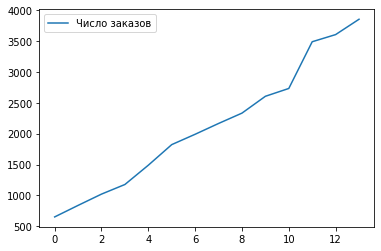

In [171]:
df.plot()

На графике рост все 14 недель

In [172]:
# названия ds и y требование библиотеки prophet

df = df.rename({'Дата': 'ds', 'Число заказов':'y'}, axis='columns')
df['ds'] = pd.to_datetime(df.ds, dayfirst=True)

In [173]:
# берем праздники из готовой бибилиотеки holidays и готовим их под вид, необходимый для prophet

holidays_dict = holidays.RU(years=(2020))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index') \
    .reset_index()
df_holidays = df_holidays.rename({'index':'ds', 0:'holiday'}, axis ='columns')
df_holidays['ds'] = pd.to_datetime(df_holidays.ds)
df_holidays = df_holidays.reset_index(drop=True)

In [174]:
# Сценарий дальнейших действий: я построю тестовую модель и дальше попробую добавить регрессор в виде одной особой недели
# несколькими способами. У какого способа будет наименьшая ошибка, таким и построю прогноз на 3 месяца

In [175]:
# Для тестовой модели возьму все данные минус последние три недели

prediction = 3
train_df = df[:-prediction]

In [176]:
# передаем prophet все данные

m = Prophet(holidays=df_holidays, seasonality_mode='multiplicative', holidays_prior_scale=10)
m.fit(train_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


In [177]:
# прогноз на три недели

future = m.make_future_dataframe(periods=3, freq='W')
forecast = m.predict(future)

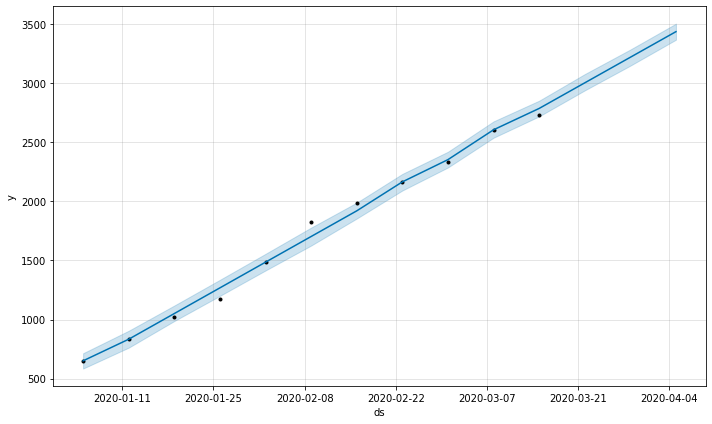

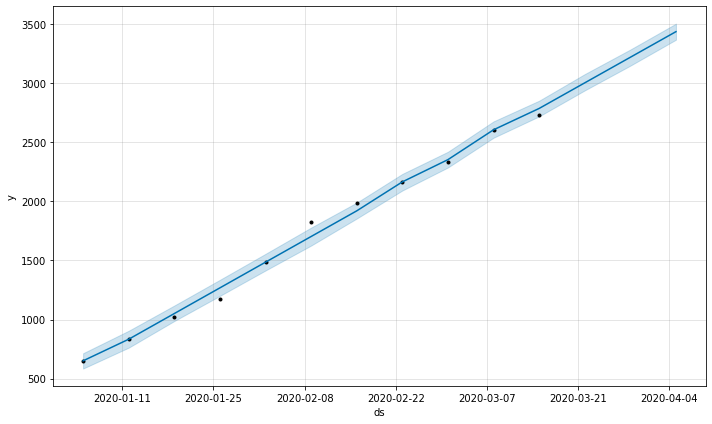

In [178]:
m.plot(forecast)

In [179]:
# Похоже на правду

forecast.tail(3).yhat

11    3005.286387
12    3222.173001
13    3439.059615
Name: yhat, dtype: float64

In [180]:
# Сложные готовые расчеты для ошибки модели

cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE (средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[-prediction:]['p'])),'%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[-prediction:]['e'])))

MAPE (средняя абсолютная ошибка в процентах) –  11.822502392168886 %
MAE (средняя абсолютная ошибка) –  430.160332230741


In [181]:
# Теперь попробую добавить регрессор с помощью встроенных в prophet методов
# Добавлю в исходный датафрейм столбец регрессора

In [182]:
def reg(data):
    if str(data) == '2020-02-09 00:00:00':
        return 0.93
    else:
        return 1

In [183]:
df['reg'] = df['ds'].apply(reg)

In [184]:
# c помощью метода add_regressor добавляем регрессор

prediction = 3
train_df = df[:-prediction]

m = Prophet(holidays=df_holidays, seasonality_mode='multiplicative', holidays_prior_scale=10)
m.add_regressor('reg', prior_scale=1.0, mode='additive')
m.fit(train_df)

future = m.make_future_dataframe(periods=3, freq='W')
future['reg'] = future['ds'].apply(reg)
forecast = m.predict(future)

cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE (средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[-prediction:]['p'])),'%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[-prediction:]['e'])))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


MAPE (средняя абсолютная ошибка в процентах) –  13.477052142799401 %
MAE (средняя абсолютная ошибка) –  490.8598950073797


Ошибка больше, чем без регрессора

In [185]:
# Теперь я просто уменьшу значение на 7% на этой недели

df = pd.read_csv('https://stepik.org/media/attachments/lesson/426638/test2_completed.csv')
df = df.rename({'Дата': 'ds', 'Число заказов':'old_y'}, axis='columns')
df['ds'] = pd.to_datetime(df.ds, dayfirst=True)

def delaction(data):
    if data == 1823:
        return 1823 * 0.93
    else:
        return data
df['y'] = df['old_y'].apply(delaction)

In [186]:
prediction = 3
train_df = df[:-prediction]

m = Prophet(holidays=df_holidays, seasonality_mode='multiplicative', holidays_prior_scale=10)
m.fit(train_df)

future = m.make_future_dataframe(periods=3, freq='W')
forecast = m.predict(future)

cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE (средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[-prediction:]['p'])),'%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[-prediction:]['e'])))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


MAPE (средняя абсолютная ошибка в процентах) –  13.38531254517182 %
MAE (средняя абсолютная ошибка) –  487.47765228931166


Почти как со встроенным методом

In [187]:
# Вариант без всего показал наименьшую ошибку. Прогнозирую три месяца с его помошью

prediction_weeks = 13
final_train_df = df
f = Prophet(holidays=df_holidays, seasonality_mode='multiplicative', holidays_prior_scale=1)
f.fit(final_train_df)
final_future = f.make_future_dataframe(periods=prediction_weeks, freq='W')
final_forecast = f.predict(final_future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


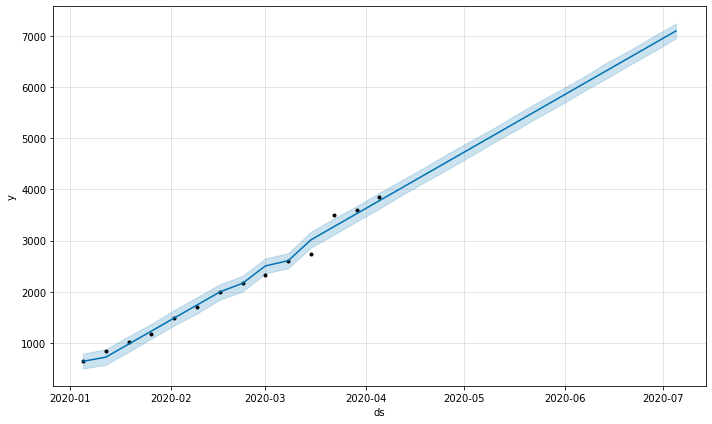

In [188]:
f.plot(final_forecast)

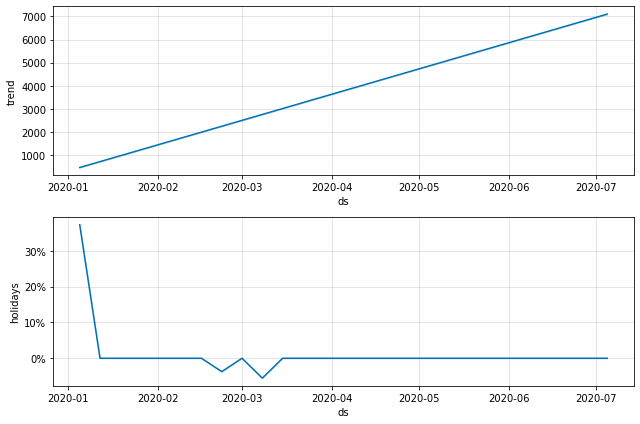

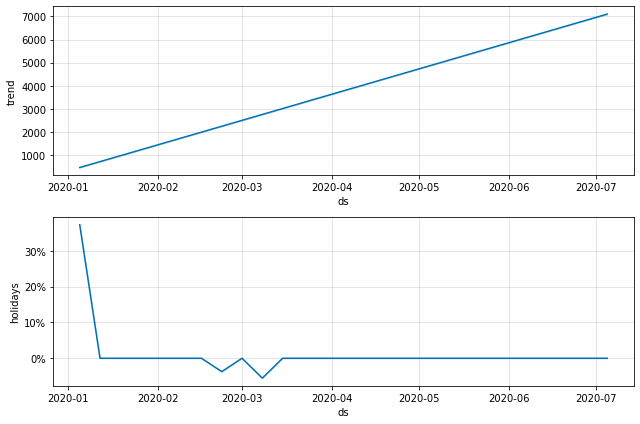

In [190]:
m.plot_components(final_forecast)